In [1]:
%matplotlib inline

import numpy as np
import power_laws
import matplotlib.colors
import seaborn as sns
import pandas as pd
import rubisco_data

from scipy import stats
from matplotlib import pyplot as plt

In [2]:
# Load the data from Excel, remove data points that are not comparable.
# raw_kin_df is everything in the file, kin_df is the subset with all relevant kinetic data.
raw_kin_df, kin_df = rubisco_data.load_rubisco_data()

# Subset the data in various ways for future use
raw_kin_df, savir_df, nonsavir_df = rubisco_data.filter_data(raw_kin_df)

# Group by RuBisCO form
grouped_form = raw_kin_df.groupby('isoform')

# Markers we use for plotting below.
markers = 'o><^dsphH*'

cnames = ["windows blue", "amber", "greyish brown", "dusty purple", "dusty teal", "dusty red", ]
named_colors = sns.xkcd_palette(cnames)

In [3]:
# Categories used to color enzymes by the physiology of their host organisms. 

# Note: it's challenging to come up with a uniform taxonomy for autotrophs because the
# important physiological characteristics (e.g. C4, CAM, carboxysome CCMs) are polyphyletic.
# The ad-hoc taxonomy in our supplementary file could probably be improved. However, for
# the purposes of this work, we "lump" together some of the groups for which there is
# limited data - groups like heterokonts and haptophytes, which are phylogenetically disparate
# algae for which we have limited Rubisco data. 

group_mapping = {'C3 plants': 'C3 plants',
                 'C3-C4 plants': 'C3-C4 plants',
                 'Cyanobacteria': 'Cyanobacteria',
                 'C4 plants': 'C4 plants',
                 'Fern': 'Other plants',
                 'C4-like plants': 'Other plants',
                 'Gymnosperm': 'Other plants',
                 'Basal angiosperm': 'Other plants',
                 'Carnivorous plants': 'Other plants',
                 'Bryophyte': 'Other plants',
                 'CAM plants': 'Other plants',
                 'Green algae': 'Green algae',
                 'Diatoms': 'Diatoms',
                 'Chromophyte algae': 'Other algae',
                 'Haptophyte algae': 'Other algae',
                 'Rhodophyte algae': 'Other algae',
                 'Macroalgae': 'Other algae',
                 'Red algae': 'Red algae',
                 'Alphaproteobacteria': 'Proteobacteria',
                 'Betaproteobacteria': 'Proteobacteria',
                 'Gammaproteobacteria': 'Proteobacteria',
                 'Archaea': 'Archaea',
                }
color_mapping = {
    'C3-C4 plants': 'very light brown',
    'C4 plants': 'pea soup',
    'C3 plants': 'dusty green',
    'Other plants': 'grey/green',
    'Cyanobacteria': 'dark blue green',
    'Green algae': 'dusty teal',
    'Red algae': 'dusty red',
    'Diatoms': 'gunmetal',
    'Other algae': 'muddy brown',
    'Proteobacteria': 'dusty rose',
    'Archaea': 'grey',
}
fancy_labels = {
    'C3-C4 plants': '$C_3$-$C_4$ plants',
    'C4 plants': '$C_4$ plants',
    'C3 plants': '$C_3$ plants',
}
label2color = dict((fancy_labels.get(k, k), sns.xkcd_rgb[color_mapping.get(k)])
                   for k in color_mapping.keys())

grouped_taxa = raw_kin_df.set_index('taxonomy').groupby(group_mapping)
counts_by_taxa = grouped_taxa.count()['species']
counts_by_taxa.sort_values(ascending=False)

C3 plants         217
C4 plants          44
Cyanobacteria      30
Proteobacteria     19
Diatoms            18
Other plants       17
C3-C4 plants       10
Other algae         7
Red algae           6
Green algae         6
Archaea             6
Name: species, dtype: int64

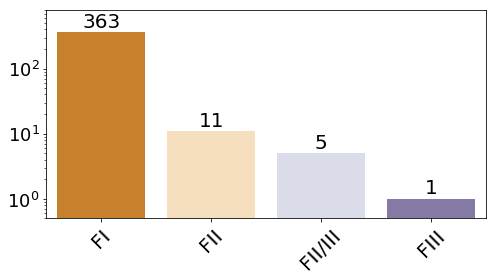

In [4]:
# Breakdown of whole dataset by isoform
isoform_counts = raw_kin_df.isoform.value_counts()

groups = {'1': 'FI', 
          '2': 'FII',
          '2_3': 'FII/III', 
          '3': 'FIII'}

fig = plt.figure(figsize=(7,4))

plt.yscale('log')
sns.barplot(y=isoform_counts, x=isoform_counts.index, palette='PuOr')
plt.xticks()

for i, (label, count) in enumerate(isoform_counts.iteritems()):
    plt.text(i, 1.2*count, str(count), ha='center', fontsize=20)

plt.ylim(0.5, 800)
plt.ylabel('', fontsize=18)
plt.yticks(fontsize=18)

xticks = [groups[i] for i in isoform_counts.index]
plt.xticks(np.arange(isoform_counts.size), xticks, fontsize=20, rotation=45, ha='center')
plt.tight_layout()

plt.savefig('fig3/fig3_isoform_counts.png', dpi=600)

plt.show()

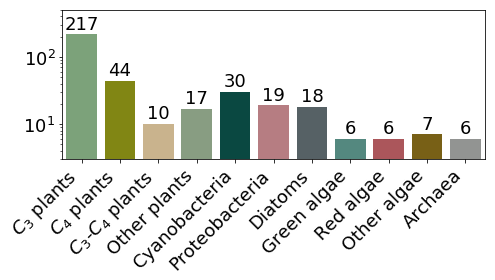

In [5]:
# Breakdown of whole dataset by physiology
fig = plt.figure(figsize=(7,4))

tax_order = ['C3 plants', 'C4 plants', 'C3-C4 plants', 'Other plants', 
             'Cyanobacteria', 'Proteobacteria', 
             'Diatoms', 'Green algae', 'Red algae', 'Other algae', 'Archaea']
counts2plot = counts_by_taxa[tax_order]

ys = np.array(counts2plot)
labels = [fancy_labels.get(k, k) for k in counts2plot.index]

plt.yscale('log')
sns.barplot(y=ys, x=labels, palette=label2color)
for i, (label, count) in enumerate(zip(labels, ys)):
    plt.text(i, 1.2*count, str(count), ha='center', fontsize=18)

plt.ylim(3, 500)
plt.xticks(fontsize=18, rotation=45, ha='right')
plt.yticks(fontsize=18)

plt.tight_layout()
plt.savefig('fig3/fig3_taxonomy_counts.png', dpi=600)

plt.show()


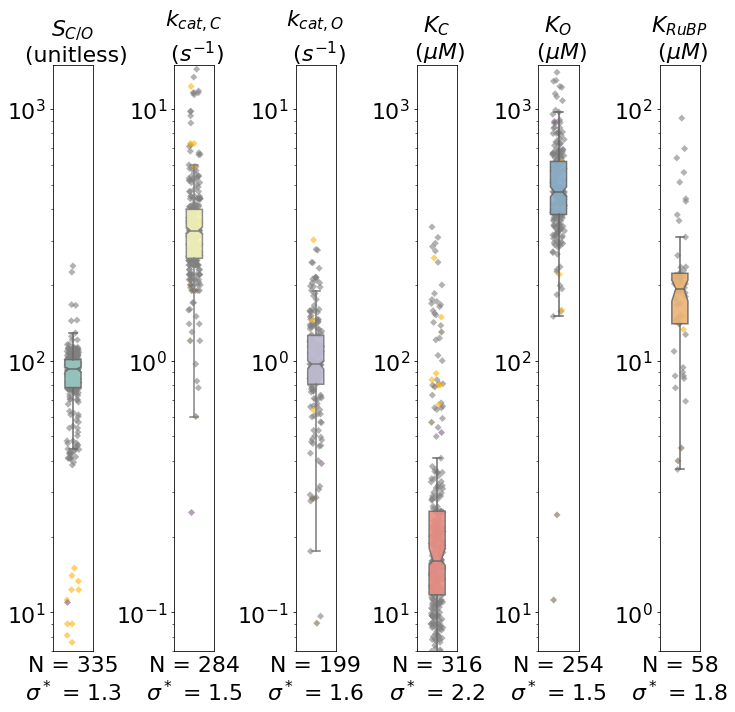

In [10]:
# Description of the data set
figure = plt.figure(figsize=(10,10))

cols = ['S', 'vC', 'vO', 'KC', 'KO', 'KRuBP']
titles = {'S': '$S_{C/O}$', 'vC': '$k_{cat,C}$', 'KC':
          '$K_C$', 'vO': '$k_{cat,O}$', 'KO': '$K_O$',
          'KRuBP': '$K_{RuBP}$'}
units = {'S': 'unitless', 'vC': '$s^{-1}$', 'KC':
         '$\mu M$', 'vO': '$s^{-1}$', 'KO': '$\mu M$',
         'KRuBP': '$\mu M$'}
ylim = {'S': (7, 1500),
        'vC': (0.7e-1, 1.5e1),
        'vO':(0.7e-1, 1.5e1),
        'KC': (7, 1.5e3),
        'KO': (7, 1.5e3),
        'KRuBP': (0.7, 1.5e2)}

nsub = len(cols)
pal = sns.color_palette('Set3')

for i, c in enumerate(cols):
    mask = raw_kin_df[c].notnull()
    vals = raw_kin_df[mask][c]
    
    ax = plt.subplot(1, nsub, i+1)
    plt.yscale('log')
    sigma_star = None

    for j, (group, gdf) in enumerate(raw_kin_df.groupby('isoform')):
        color = named_colors[j]
        if group == '1':
            color = 'grey'
            sigma_star = power_laws.sigma_star(gdf[c])
            
        sns.stripplot(y=gdf[c], color=color, jitter=0.15, size=5, marker='D',
                      alpha=0.6, zorder=-1)
        
    sns.boxplot(y=raw_kin_df[c], color=pal[i], width=0.4, notch=True, bootstrap=1000, zorder=10,
                boxprops=dict(alpha=.9), showfliers=False)
            
    nvals = raw_kin_df[c].notnull().sum()
    xlabel = 'N = %d\n$\sigma^*$ = %.1f' % (nvals, sigma_star)

    plt.ylim(*ylim[c])
    plt.xticks([])
    plt.yticks(fontsize=22)
    plt.ylabel('')
    plt.xlabel(xlabel, fontsize=22, ha='center')
    
    title = '%s \n (%s)' % (titles[c], units[c])
    plt.title(title, fontsize=22)
    
plt.subplots_adjust(wspace=0.1)
plt.tight_layout()

plt.savefig('fig3/fig3_data_summary.png', dpi=600, bbox_inches='tight', pad_inches=0.2)

plt.show()

In [16]:
# print some statistics about the full dataset
full_dataset_df = pd.read_csv('../data/DatasetS4_RubiscoKineticsFull_Merged.csv')

# TODO correct minor errors in long refs
mask = full_dataset_df.use & np.logical_not(full_dataset_df.mutant)
refs = full_dataset_df[mask].short_ref.unique().size

print('Data from', refs, 'references used')

Data from 61 references


In [8]:
# print some statistics about the data passing filters
print(raw_kin_df.shape[0], 'total WT RuBisCOs')
print(raw_kin_df.species.unique().size, 'total unique species')
print(kin_df.shape[0], 'RuBisCOs with all core kinetic data measured')
print(kin_df.species.unique().size, 'unique species among those with core kinetic data')

print(raw_kin_df.kon_C.notnull().sum(), 'kcatC/KC values overall')
print(raw_kin_df.kon_O.notnull().sum(), 'kcatO/KO values overall')

380 total WT RuBisCOs
304 total unique species
208 RuBisCOs with all core kinetic data measured
184 unique species among those with core kinetic data
274 kcatC/KC values overall
199 kcatO/KO values overall


In [9]:
# Counts by taxa. I realize that these categories are not strictly
# mutually exclusive, but we did our best mapping a tree onto 1D.
species_counts = raw_kin_df.species.value_counts()
species_counts

Spinacia oleracea                        12
Synechococcus 6301                       10
Rhodospirillum rubrum                     9
Nicotiana tabacum                         8
Triticum aestivum                         7
Zea mays                                  4
Flaveria pringlei                         4
Glycine max                               3
Amaranthus hybridus                       3
Espeletia schultzii                       3
Chlamydomonas reinhardtii                 3
Arabidopsis thaliana                      3
Methanococcoides burtonii                 3
Synechococcus 7002                        3
Nicotiana tabacum L. cv. W38              2
Cyanobium PCC7001                         2
Sorghum bicolor                           2
Rhodobacter sphaeroides I                 2
Cylindrotheca N1                          2
Manihot esculenta                         2
Limonium gibertii                         2
Flaveria floridana                        2
Setaria viridis                 